# Lab 1: Introduction to Genetic Genealogy and IBD Concepts

## Overview

This lab introduces the foundational concepts of genetic genealogy and Identity-by-Descent (IBD) that underpin the Bonsai v3 system. Through practical exercises, we'll explore:

1. The biological foundations of genetic inheritance
2. Identity-by-Descent (IBD) concepts and detection
3. How IBD patterns reveal genealogical relationships
4. The fundamental principles of pedigree reconstruction

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from IPython.display import display, HTML, Markdown

In [11]:
# ============================================
# 📋 Environment Detection
# ============================================

def is_colab():
    '''Check if running in Google Colab'''
    try:
        import google.colab
        return True
    except ImportError:
        return False

def mount_google_drive(mount_point="/content/drive"):
    '''Mount Google Drive in Colab'''
    if not is_colab():
        print("❌ Google Drive mounting is only available in Google Colab")
        return None

    try:
        from google.colab import drive
        drive.mount(mount_point)
        print(f"✅ Google Drive mounted at {mount_point}")
        print(f"📁 Your files are available at: {mount_point}/MyDrive/")
        return f"{mount_point}/MyDrive"
    except Exception as e:
        print(f"❌ Failed to mount Google Drive: {e}")
        return None

def setup_colab_environment():
    '''Set up Google Colab with required packages'''
    print("🔬 Setting up Google Colab environment...")

    # Install Python packages
    print("📦 Installing Python packages...")
    os.system("pip install -q pysam biopython scikit-allel networkx pygraphviz seaborn plotly")

    # Install system packages
    print("🔧 Installing system packages...")
    os.system("apt-get update -qq && apt-get install -qq samtools bcftools tabix graphviz-dev")

    # Create directories
    os.makedirs("/content/class_data", exist_ok=True)
    os.makedirs("/content/results", exist_ok=True)

    print("✅ Colab setup complete!")
    return "/content/class_data", "/content/results"

def setup_local_environment():
    '''Set up local environment'''
    print("🏠 Local environment detected")
    os.makedirs("class_data", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    return "class_data", "results"

# ============================================
# 📥 Data Download Functions
# ============================================

def download_class_data(data_dir="/content/class_data", files_to_download=None):
    '''Download class data files from S3'''
    if not is_colab():
        print("⚠️  Data download is configured for Google Colab. For local use, please download manually.")
        return

    S3_BASE = "https://computational-genetic-genealogy.s3.us-east-2.amazonaws.com/class_data/"

    # Default file list
    default_files = [
        "pedigree.fam",
        "pedigree.def",
        "merged_opensnps_autosomes_ped_sim.seg",
        "merged_opensnps_autosomes_ped_sim-everyone.fam",
        "ped_sim_run2.seg",
        "ped_sim_run2-everyone.fam"
    ]

    files = files_to_download or default_files

    print(f"📥 Downloading {len(files)} files to {data_dir}...")

    for file in files:
        file_path = os.path.join(data_dir, file)
        if os.path.exists(file_path):
            print(f"  ⏭️  {file} already exists, skipping...")
            continue

        url = f"{S3_BASE}{file}"
        os.system(f"wget -q -O {file_path} {url}")

        if os.path.exists(file_path):
            print(f"  ✅ {file}")
        else:
            print(f"  ❌ Failed to download {file}")

# ============================================
# 📊 Utility Functions
# ============================================

def save_results(dataframe, filename, description="results"):
    '''Save dataframe and provide download instructions'''
    full_path = os.path.join(RESULTS_DIR, filename)
    dataframe.to_csv(full_path, index=False)

    if is_colab():
        display(HTML(f'''
        <div style="padding: 10px; background-color: #e3f2fd; border-left: 4px solid #2196f3; margin: 10px 0;">
            <p><strong>💾 {description} saved!</strong></p>
            <p>File: <code>{full_path}</code></p>
            <p>To download: <code>from google.colab import files; files.download('{full_path}')</code></p>
        </div>
        '''))
    else:
        print(f"💾 {description} saved to: {full_path}")

    return full_path

def save_plot(plt_or_fig, filename, description="plot"):
    '''Save plot and provide download instructions'''
    full_path = os.path.join(RESULTS_DIR, filename)

    # Handle both plt and figure objects
    if hasattr(plt_or_fig, 'savefig'):
        plt_or_fig.savefig(full_path, dpi=300, bbox_inches='tight')
    else:
        plt_or_fig.savefig(full_path, dpi=300, bbox_inches='tight')
        plt_or_fig.show()

    if is_colab():
        display(HTML(f'''
        <div style="padding: 10px; background-color: #e8f5e9; border-left: 4px solid #4caf50; margin: 10px 0;">
            <p><strong>📊 {description} saved!</strong></p>
            <p>File: <code>{full_path}</code></p>
            <p>To download: <code>from google.colab import files; files.download('{full_path}')</code></p>
        </div>
        '''))
    else:
        print(f"📊 {description} saved to: {full_path}")

    return full_path

In [4]:
# Mount Google Drive (optional)
drive_path = mount_google_drive()

Mounted at /content/drive
✅ Google Drive mounted at /content/drive
📁 Your files are available at: /content/drive/MyDrive/


In [12]:
if is_colab():
    DATA_DIR, RESULTS_DIR = setup_colab_environment()
else:
    DATA_DIR, RESULTS_DIR = setup_local_environment()

🔬 Setting up Google Colab environment...
📦 Installing Python packages...
🔧 Installing system packages...
✅ Colab setup complete!


In [13]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook")

print("\n✨ Environment setup complete!")
print(f"📁 Data directory: {DATA_DIR}")
print(f"📁 Results directory: {RESULTS_DIR}")


✨ Environment setup complete!
📁 Data directory: /content/class_data
📁 Results directory: /content/results


In [14]:
# Download data (optional)
download_class_data()

# # Download only specific files
# download_class_data(files_to_download=["pedigree.fam", "pedigree.def"])

📥 Downloading 6 files to /content/class_data...
  ✅ pedigree.fam
  ✅ pedigree.def
  ✅ merged_opensnps_autosomes_ped_sim.seg
  ✅ merged_opensnps_autosomes_ped_sim-everyone.fam
  ✅ ped_sim_run2.seg
  ✅ ped_sim_run2-everyone.fam


## Introduction to Genetic Genealogy

Genetic genealogy is the application of genetic analysis to traditional genealogical methods. By analyzing patterns of DNA sharing between individuals, we can infer their biological relationships and reconstruct family trees.

The key principle underlying genetic genealogy is that DNA is inherited from our biological parents, with specific patterns of transmission that allow us to identify and quantify relationships.

### Biological Foundations: DNA Inheritance

Let's visualize the basic pattern of DNA inheritance through generations:

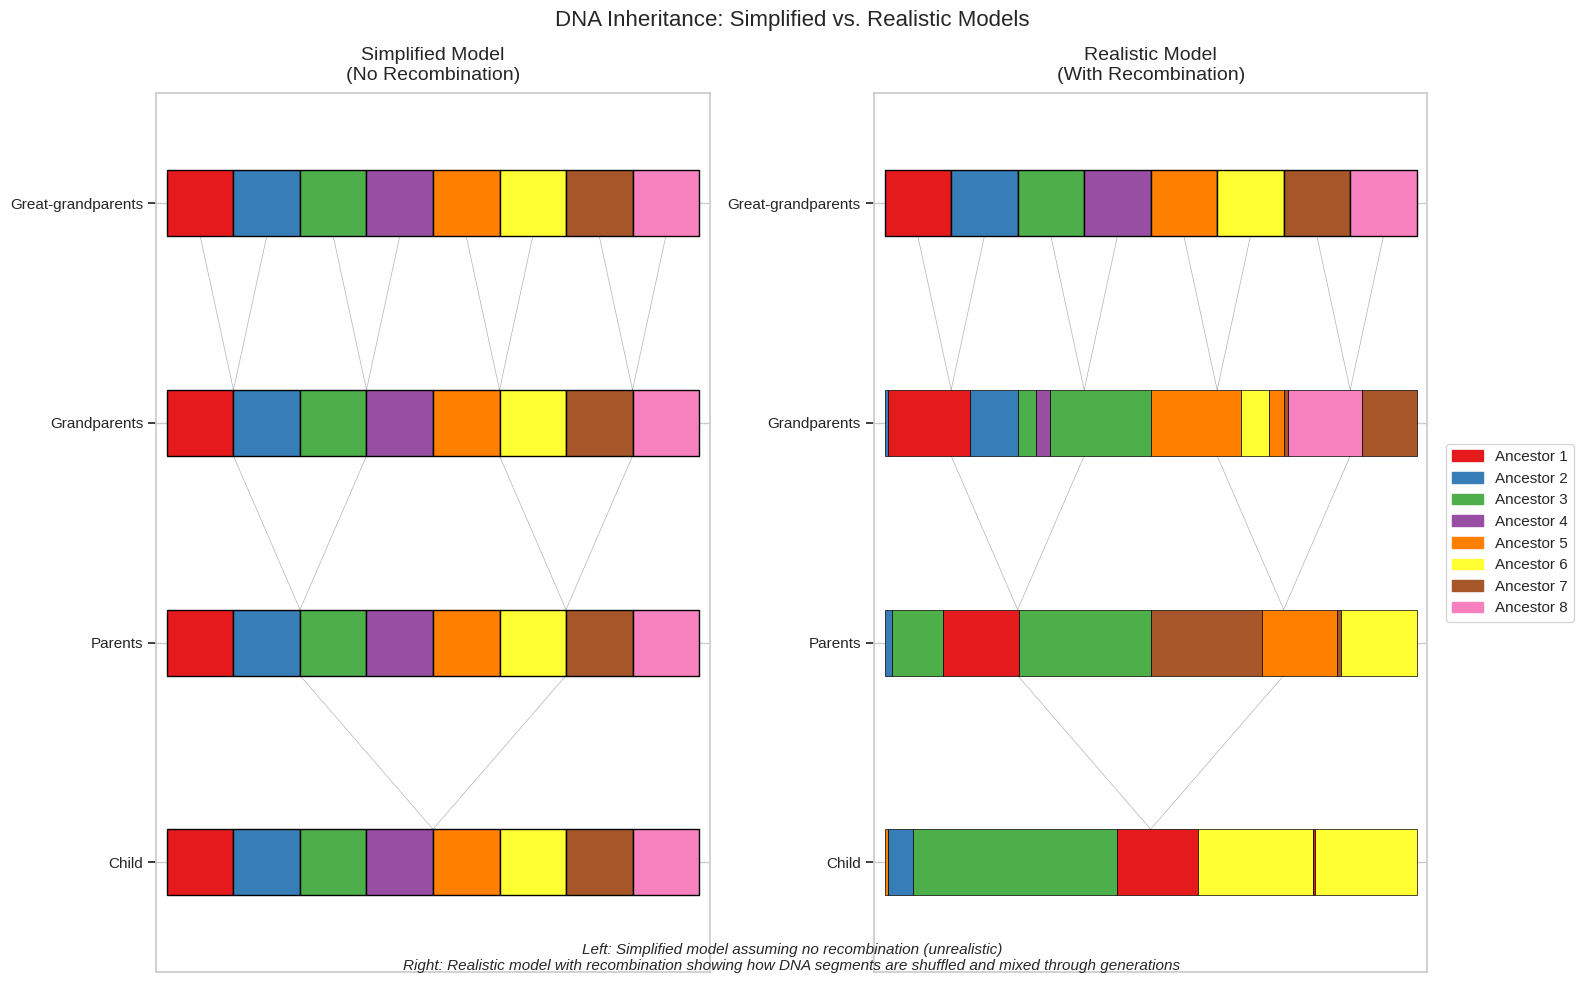

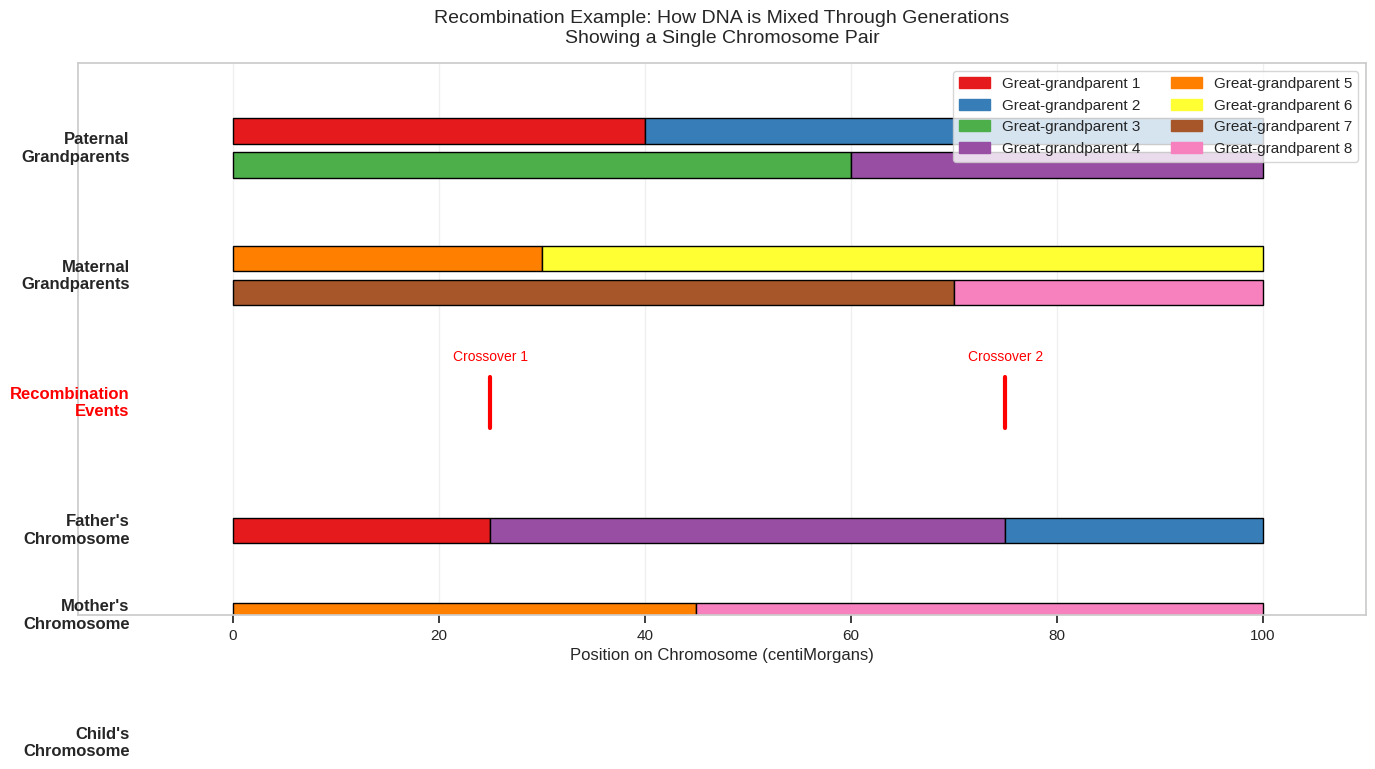

In [17]:
# Create a more realistic visualization showing recombination
import random
np.random.seed(42)  # For reproducibility
random.seed(42)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))

# Colors for different ancestral contributions
colors = ['#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00', '#FFFF33', '#A65628', '#F781BF']

# ========================================
# Left plot: Simplified inheritance (no recombination)
# ========================================
ax1.set_title('Simplified Model\n(No Recombination)', fontsize=14, pad=10)

# Set up the generations
generations = 4
y_positions = [3, 2, 1, 0]
generation_labels = ["Great-grandparents", "Grandparents", "Parents", "Child"]

# Plot great-grandparents
for i in range(8):
    x_start = i / 8
    ax1.barh(y_positions[0], 1/8, left=x_start, height=0.3,
             color=colors[i], edgecolor='black', linewidth=1)

# Plot grandparents (no mixing)
for i in range(4):
    x_start = i / 4
    # Grandparent gets DNA from two great-grandparents
    ax1.barh(y_positions[1], 1/8, left=x_start, height=0.3,
             color=colors[i*2], edgecolor='black', linewidth=1)
    ax1.barh(y_positions[1], 1/8, left=x_start + 1/8, height=0.3,
             color=colors[i*2 + 1], edgecolor='black', linewidth=1)

# Plot parents (no mixing)
for i in range(2):
    x_start = i / 2
    # Each parent segment
    for j in range(4):
        ancestor_idx = i*4 + j
        ax1.barh(y_positions[2], 1/8, left=x_start + j/8, height=0.3,
                 color=colors[ancestor_idx], edgecolor='black', linewidth=1)

# Plot child (equal chunks from each ancestor)
for i in range(8):
    ax1.barh(y_positions[3], 1/8, left=i/8, height=0.3,
             color=colors[i], edgecolor='black', linewidth=1)

# ========================================
# Right plot: Realistic inheritance with recombination
# ========================================
ax2.set_title('Realistic Model\n(With Recombination)', fontsize=14, pad=10)

# Function to create recombination segments
def create_recombined_segments(parent1_segments, parent2_segments, num_crossovers=3):
    """Simulate recombination between two parents"""
    # Create crossover points
    crossover_points = sorted([0] + [random.random() for _ in range(num_crossovers)] + [1])

    result_segments = []
    current_parent = random.choice([0, 1])  # Randomly start with parent 1 or 2

    for i in range(len(crossover_points) - 1):
        start = crossover_points[i]
        end = crossover_points[i + 1]

        # Find which segments from the current parent overlap this region
        parent_segments = parent1_segments if current_parent == 0 else parent2_segments

        for seg in parent_segments:
            seg_start, seg_end, seg_color = seg
            # Calculate overlap
            overlap_start = max(start, seg_start)
            overlap_end = min(end, seg_end)

            if overlap_start < overlap_end:
                result_segments.append((overlap_start, overlap_end, seg_color))

        # Switch parent for next segment
        current_parent = 1 - current_parent

    return result_segments

# Initialize great-grandparents (each has pure DNA)
ggp_dna = []
for i in range(8):
    ggp_dna.append([(0, 1, colors[i])])

# Plot great-grandparents
for i in range(8):
    x_start = i / 8
    ax2.barh(y_positions[0], 1/8, left=x_start, height=0.3,
             color=colors[i], edgecolor='black', linewidth=1)

# Generate grandparents' DNA through recombination
gp_dna = []
for i in range(4):
    parent1_idx = i * 2
    parent2_idx = i * 2 + 1
    # Each grandparent gets recombined DNA from two great-grandparents
    recombined = create_recombined_segments(ggp_dna[parent1_idx], ggp_dna[parent2_idx], 2)
    gp_dna.append(recombined)

    # Plot grandparent
    x_base = i / 4
    for seg_start, seg_end, seg_color in recombined:
        ax2.barh(y_positions[1], (seg_end - seg_start) / 4,
                left=x_base + seg_start / 4, height=0.3,
                color=seg_color, edgecolor='black', linewidth=0.5)

# Generate parents' DNA through recombination
parent_dna = []
for i in range(2):
    parent1_idx = i * 2
    parent2_idx = i * 2 + 1
    # Normalize grandparent segments to [0, 1] range for recombination
    gp1_normalized = [(s*4 - parent1_idx, e*4 - parent1_idx, c) for s, e, c in gp_dna[parent1_idx]]
    gp2_normalized = [(s*4 - parent2_idx, e*4 - parent2_idx, c) for s, e, c in gp_dna[parent2_idx]]

    recombined = create_recombined_segments(gp1_normalized, gp2_normalized, 3)
    parent_dna.append(recombined)

    # Plot parent
    x_base = i / 2
    for seg_start, seg_end, seg_color in recombined:
        ax2.barh(y_positions[2], (seg_end - seg_start) / 2,
                left=x_base + seg_start / 2, height=0.3,
                color=seg_color, edgecolor='black', linewidth=0.5)

# Generate child's DNA through recombination
# Normalize parent segments
parent1_normalized = [(s*2, e*2, c) for s, e, c in parent_dna[0]]
parent2_normalized = [(s*2 - 1, e*2 - 1, c) for s, e, c in parent_dna[1]]

child_dna = create_recombined_segments(parent1_normalized, parent2_normalized, 4)

# Plot child
for seg_start, seg_end, seg_color in child_dna:
    ax2.barh(y_positions[3], seg_end - seg_start,
            left=seg_start, height=0.3,
            color=seg_color, edgecolor='black', linewidth=0.5)

# Format both plots
for ax in [ax1, ax2]:
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.5, 3.5)
    ax.set_yticks(y_positions)
    ax.set_yticklabels(generation_labels)
    ax.set_xticks([])

    # Add lines showing inheritance
    for gen in range(3):
        if gen == 0:  # Great-grandparents to grandparents
            for i in range(4):
                # From each pair of great-grandparents to one grandparent
                ax.plot([i*2/8 + 1/16, i/4 + 1/8], [y_positions[0] - 0.15, y_positions[1] + 0.15],
                       'k-', alpha=0.3, linewidth=0.5)
                ax.plot([(i*2+1)/8 + 1/16, i/4 + 1/8], [y_positions[0] - 0.15, y_positions[1] + 0.15],
                       'k-', alpha=0.3, linewidth=0.5)
        elif gen == 1:  # Grandparents to parents
            for i in range(2):
                # From each pair of grandparents to one parent
                ax.plot([i*2/4 + 1/8, i/2 + 1/4], [y_positions[1] - 0.15, y_positions[2] + 0.15],
                       'k-', alpha=0.3, linewidth=0.5)
                ax.plot([(i*2+1)/4 + 1/8, i/2 + 1/4], [y_positions[1] - 0.15, y_positions[2] + 0.15],
                       'k-', alpha=0.3, linewidth=0.5)
        else:  # Parents to child
            ax.plot([1/4, 1/2], [y_positions[2] - 0.15, y_positions[3] + 0.15],
                   'k-', alpha=0.3, linewidth=0.5)
            ax.plot([3/4, 1/2], [y_positions[2] - 0.15, y_positions[3] + 0.15],
                   'k-', alpha=0.3, linewidth=0.5)

# Add legend
ancestor_patches = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(8)]
ax2.legend(ancestor_patches, [f"Ancestor {i+1}" for i in range(8)],
          loc='center left', bbox_to_anchor=(1.02, 0.5), frameon=True, fancybox=True)

# Add overall title and notes
fig.suptitle('DNA Inheritance: Simplified vs. Realistic Models', fontsize=16, y=0.98)
fig.text(0.5, 0.02,
         'Left: Simplified model assuming no recombination (unrealistic)\n' +
         'Right: Realistic model with recombination showing how DNA segments are shuffled and mixed through generations',
         ha='center', fontsize=11, style='italic')

plt.tight_layout()
save_plot(fig, "dna_recombination_comparison.png", "DNA Recombination Comparison")
plt.show()

# Now let's create a detailed view of a single chromosome showing recombination
fig2, ax = plt.subplots(figsize=(14, 8))

# Simulate one chromosome through three generations
chromosome_length = 100  # in centiMorgans

# Parent 1 chromosome (from grandparents)
gp1_segments = [(0, 40, colors[0]), (40, 100, colors[1])]
gp2_segments = [(0, 60, colors[2]), (60, 100, colors[3])]

# Parent 2 chromosome (from other grandparents)
gp3_segments = [(0, 30, colors[4]), (30, 100, colors[5])]
gp4_segments = [(0, 70, colors[6]), (70, 100, colors[7])]

# Show the process
y_pos = 5

# Grandparents' chromosomes
ax.text(-10, y_pos, "Paternal\nGrandparents", ha='right', va='center', fontweight='bold')
for start, end, color in gp1_segments:
    ax.barh(y_pos + 0.2, end - start, left=start, height=0.3, color=color, edgecolor='black')
for start, end, color in gp2_segments:
    ax.barh(y_pos - 0.2, end - start, left=start, height=0.3, color=color, edgecolor='black')

y_pos -= 1.5
ax.text(-10, y_pos, "Maternal\nGrandparents", ha='right', va='center', fontweight='bold')
for start, end, color in gp3_segments:
    ax.barh(y_pos + 0.2, end - start, left=start, height=0.3, color=color, edgecolor='black')
for start, end, color in gp4_segments:
    ax.barh(y_pos - 0.2, end - start, left=start, height=0.3, color=color, edgecolor='black')

# Show recombination events
y_pos -= 1.5
ax.text(-10, y_pos, "Recombination\nEvents", ha='right', va='center', fontweight='bold', color='red')
ax.plot([25, 25], [y_pos - 0.3, y_pos + 0.3], 'r-', linewidth=3)
ax.plot([75, 75], [y_pos - 0.3, y_pos + 0.3], 'r-', linewidth=3)
ax.text(25, y_pos + 0.5, "Crossover 1", ha='center', color='red', fontsize=10)
ax.text(75, y_pos + 0.5, "Crossover 2", ha='center', color='red', fontsize=10)

# Parents' chromosomes (after recombination)
y_pos -= 1.5
ax.text(-10, y_pos, "Father's\nChromosome", ha='right', va='center', fontweight='bold')
# Simulate recombination for father
father_segments = [(0, 25, colors[0]), (25, 75, colors[3]), (75, 100, colors[1])]
for start, end, color in father_segments:
    ax.barh(y_pos, end - start, left=start, height=0.3, color=color, edgecolor='black')

y_pos -= 1
ax.text(-10, y_pos, "Mother's\nChromosome", ha='right', va='center', fontweight='bold')
# Simulate recombination for mother
mother_segments = [(0, 45, colors[4]), (45, 100, colors[7])]
for start, end, color in mother_segments:
    ax.barh(y_pos, end - start, left=start, height=0.3, color=color, edgecolor='black')

# Child's chromosome (after another recombination)
y_pos -= 1.5
ax.text(-10, y_pos, "Child's\nChromosome", ha='right', va='center', fontweight='bold')
# Simulate final recombination
child_segments = [(0, 15, colors[0]), (15, 45, colors[3]), (45, 60, colors[7]),
                  (60, 75, colors[3]), (75, 100, colors[1])]
for start, end, color in child_segments:
    ax.barh(y_pos, end - start, left=start, height=0.3, color=color, edgecolor='black')

# Format
ax.set_xlim(-15, 110)
ax.set_ylim(-0.5, 6)
ax.set_xlabel('Position on Chromosome (centiMorgans)', fontsize=12)
ax.set_title('Recombination Example: How DNA is Mixed Through Generations\nShowing a Single Chromosome Pair',
             fontsize=14, pad=15)
ax.set_yticks([])

# Add grid
ax.grid(True, axis='x', alpha=0.3)

# Add legend
ancestor_patches = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(8)]
ax.legend(ancestor_patches, [f"Great-grandparent {i+1}" for i in range(8)],
         loc='upper right', ncol=2, frameon=True, fancybox=True)

plt.tight_layout()
save_plot(fig2, "chromosome_recombination_detail.png", "Chromosome Recombination Detail")
plt.show()

### Key Principles of Genetic Inheritance:

1. **Autosomal DNA**: Each person inherits approximately 50% of their autosomal DNA from each parent
2. **Recombination**: During meiosis, chromosomes exchange segments, creating unique combinations of ancestral DNA
3. **Random Inheritance**: Which 50% you inherit from each parent is largely random
4. **Dilution Over Generations**: The amount of DNA you share with an ancestor is approximately halved each generation back

These principles create predictable patterns of DNA sharing between relatives that form the basis for genetic genealogy.

## Identity by Descent (IBD)

Identity by Descent (IBD) refers to segments of DNA that two individuals have inherited from a common ancestor. These segments are identical because they are copies of the exact same ancestral DNA segment.

IBD is the fundamental unit of genetic relatedness detection and is central to Bonsai's approach to pedigree reconstruction.

### IBD Types: IBD1 vs IBD2

There are two important types of IBD sharing:

1. **IBD1 (Half-Identical Regions)**: DNA segments where individuals share one chromosome of a pair (one allele at each position)
2. **IBD2 (Fully Identical Regions)**: DNA segments where individuals share both chromosomes of a pair (both alleles at each position)

Let's visualize these two types of IBD:

In [ ]:
# Create a visualization of IBD1 vs IBD2
plt.figure(figsize=(12, 6))

# Define the chromosome length
chrom_length = 100

# Set up the plots
plt.subplot(2, 1, 1)

# Create person A's chromosomes
plt.barh(2, chrom_length, height=0.4, color='#E41A1C', alpha=0.8)
plt.barh(1, chrom_length, height=0.4, color='#377EB8', alpha=0.8)
plt.text(-5, 1.5, "Person A", ha='right', va='center', fontweight='bold')

# Create person B's chromosomes with IBD1 region
plt.barh(0, chrom_length, height=0.4, color='#4DAF4A', alpha=0.8)
plt.barh(-1, chrom_length, height=0.4, color='#377EB8', alpha=0.8)  # Shared with Person A (IBD1)
plt.text(-5, -0.5, "Person B", ha='right', va='center', fontweight='bold')

# Highlight the IBD1 region
ibd1_start = 25
ibd1_length = 30
plt.barh(-1, ibd1_length, left=ibd1_start, height=0.4, color='#377EB8', alpha=1.0, edgecolor='black', linewidth=2)
plt.barh(1, ibd1_length, left=ibd1_start, height=0.4, color='#377EB8', alpha=1.0, edgecolor='black', linewidth=2)

# Add text labels
plt.text(ibd1_start + ibd1_length/2, 0, "IBD1 (Half-Identical Region)", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.xlim(-10, chrom_length + 10)
plt.ylim(-1.5, 2.5)
plt.xticks([])
plt.yticks([])
plt.title('IBD1: Half-Identical Region')

# Second plot for IBD2
plt.subplot(2, 1, 2)

# Create person C's chromosomes
plt.barh(2, chrom_length, height=0.4, color='#E41A1C', alpha=0.8)
plt.barh(1, chrom_length, height=0.4, color='#377EB8', alpha=0.8)
plt.text(-5, 1.5, "Person C", ha='right', va='center', fontweight='bold')

# Create person D's chromosomes with IBD2 region
plt.barh(0, chrom_length, height=0.4, color='#E41A1C', alpha=0.8)  # Shared with Person C (IBD2)
plt.barh(-1, chrom_length, height=0.4, color='#377EB8', alpha=0.8)  # Shared with Person C (IBD2)
plt.text(-5, -0.5, "Person D", ha='right', va='center', fontweight='bold')

# Highlight the IBD2 region
ibd2_start = 35
ibd2_length = 25
plt.barh(0, ibd2_length, left=ibd2_start, height=0.4, color='#E41A1C', alpha=1.0, edgecolor='black', linewidth=2)
plt.barh(2, ibd2_length, left=ibd2_start, height=0.4, color='#E41A1C', alpha=1.0, edgecolor='black', linewidth=2)
plt.barh(-1, ibd2_length, left=ibd2_start, height=0.4, color='#377EB8', alpha=1.0, edgecolor='black', linewidth=2)
plt.barh(1, ibd2_length, left=ibd2_start, height=0.4, color='#377EB8', alpha=1.0, edgecolor='black', linewidth=2)

# Add text labels
plt.text(ibd2_start + ibd2_length/2, 0, "IBD2 (Fully Identical Region)", ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))

plt.xlim(-10, chrom_length + 10)
plt.ylim(-1.5, 2.5)
plt.xticks([])
plt.yticks([])
plt.title('IBD2: Fully Identical Region')

plt.tight_layout()
plt.show()

### Measuring IBD: centiMorgans (cM)

IBD segments are typically measured in **centiMorgans (cM)**, a unit of genetic distance that accounts for recombination rates. This measurement is more relevant for inheritance analysis than physical length measures like base pairs.

Key characteristics of centiMorgans:
- 1 cM represents approximately a 1% chance of recombination in a single generation
- The human genome is about 3400 cM in length
- cM distances vary across the genome based on recombination hotspots

In [ ]:
# Visualize the relationship between physical distance (Mb) and genetic distance (cM)
# Using simplified synthetic data based on real chromosome patterns

# Create synthetic data for chromosome 1
physical_pos = np.linspace(0, 250, 1000)  # Approximate length of chromosome 1 in Mb
np.random.seed(42)  # For reproducibility

# Create genetic positions with variable recombination rates
base_rate = 1  # Base recombination rate (cM/Mb)
hotspots = np.random.choice(len(physical_pos) - 50, 10, replace=False)  # Positions of recombination hotspots

# Generate genetic positions using variable recombination rates
genetic_pos = np.zeros_like(physical_pos)
for i in range(1, len(physical_pos)):
    # Check if we're in a hotspot region
    in_hotspot = any(abs(i - h) < 20 for h in hotspots)

    # Apply appropriate recombination rate
    if in_hotspot:
        rate = base_rate * 5  # Hotspot has 5x the recombination rate
    else:
        rate = base_rate

    genetic_pos[i] = genetic_pos[i-1] + rate * (physical_pos[i] - physical_pos[i-1])

# Plot the data
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(physical_pos, genetic_pos, 'b-')
plt.xlabel('Physical Position (Mb)')
plt.ylabel('Genetic Position (cM)')
plt.title('Relationship Between Physical and Genetic Distance')
plt.grid(alpha=0.3)

# Plot recombination rate
plt.subplot(2, 1, 2)
recomb_rate = np.zeros_like(physical_pos[:-1])
for i in range(len(physical_pos) - 1):
    recomb_rate[i] = (genetic_pos[i+1] - genetic_pos[i]) / (physical_pos[i+1] - physical_pos[i])

plt.plot(physical_pos[:-1], recomb_rate, 'r-')
plt.xlabel('Physical Position (Mb)')
plt.ylabel('Recombination Rate (cM/Mb)')
plt.title('Recombination Rate Across the Chromosome')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### IBD Detection in Practice

IBD segments are detected using specialized algorithms that analyze DNA data from genotyping arrays or sequencing. Common IBD detection tools include:

1. **IBIS**: Fast and accurate IBD segment detection
2. **Refined IBD**: Precise detection with phased data
3. **HapIBD**: Modern IBD segment detector with good accuracy

Bonsai v3 is designed to work with the output from these IBD detectors, using the detected segments to infer relationships.

## IBD Patterns in Different Relationships

Different types of relationships show characteristic patterns of IBD sharing. Let's explore the expected IBD sharing for various relationship types:

In [ ]:
# Create a table of expected IBD sharing for different relationships
relationships = [
    {"relationship": "Identical twins", "meiotic_distance": 0, "expected_sharing": 100.0, "ibd1_pct": 0, "ibd2_pct": 100},
    {"relationship": "Parent-Child", "meiotic_distance": 1, "expected_sharing": 50.0, "ibd1_pct": 100, "ibd2_pct": 0},
    {"relationship": "Full siblings", "meiotic_distance": 2, "expected_sharing": 50.0, "ibd1_pct": 50, "ibd2_pct": 25},
    {"relationship": "Half-siblings", "meiotic_distance": 2, "expected_sharing": 25.0, "ibd1_pct": 50, "ibd2_pct": 0},
    {"relationship": "Grandparent-Grandchild", "meiotic_distance": 2, "expected_sharing": 25.0, "ibd1_pct": 50, "ibd2_pct": 0},
    {"relationship": "Uncle/Aunt-Nephew/Niece", "meiotic_distance": 3, "expected_sharing": 25.0, "ibd1_pct": 50, "ibd2_pct": 0},
    {"relationship": "First cousins", "meiotic_distance": 4, "expected_sharing": 12.5, "ibd1_pct": 25, "ibd2_pct": 0},
    {"relationship": "First cousins once removed", "meiotic_distance": 5, "expected_sharing": 6.25, "ibd1_pct": 12.5, "ibd2_pct": 0},
    {"relationship": "Second cousins", "meiotic_distance": 6, "expected_sharing": 3.125, "ibd1_pct": 6.25, "ibd2_pct": 0},
    {"relationship": "Second cousins once removed", "meiotic_distance": 7, "expected_sharing": 1.563, "ibd1_pct": 3.125, "ibd2_pct": 0},
    {"relationship": "Third cousins", "meiotic_distance": 8, "expected_sharing": 0.781, "ibd1_pct": 1.563, "ibd2_pct": 0},
    {"relationship": "Fourth cousins", "meiotic_distance": 10, "expected_sharing": 0.195, "ibd1_pct": 0.391, "ibd2_pct": 0},
]

# Convert to DataFrame
rel_df = pd.DataFrame(relationships)

# Display the table
rel_df

In [ ]:
# Visualize the expected total IBD sharing by relationship
plt.figure(figsize=(14, 8))

# Plot total sharing
plt.subplot(2, 1, 1)
bars = plt.bar(rel_df['relationship'], rel_df['expected_sharing'], color='#4292c6')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Expected Total IBD Sharing (%)')
plt.title('Expected IBD Sharing by Relationship Type')
plt.grid(axis='y', alpha=0.3)

# Add labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
            f'{height:.2f}%', ha='center', va='bottom')

# Plot IBD1 vs IBD2 distribution
plt.subplot(2, 1, 2)
width = 0.35
x = np.arange(len(rel_df))

plt.bar(x - width/2, rel_df['ibd1_pct'], width, label='IBD1 (Half-identical)', color='#6baed6')
plt.bar(x + width/2, rel_df['ibd2_pct'], width, label='IBD2 (Fully identical)', color='#08519c')

plt.xlabel('Relationship Type')
plt.ylabel('Genome Coverage (%)')
plt.title('IBD1 vs IBD2 Distribution by Relationship Type')
plt.xticks(x, rel_df['relationship'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Stochasticity in IBD Sharing

While we've described the expected IBD sharing for different relationships, it's important to understand that actual IBD sharing is stochastic due to the random nature of recombination and inheritance.

Let's simulate the distribution of IBD sharing for first cousins to illustrate this variability:

In [ ]:
# Simulate IBD sharing for first cousins
np.random.seed(42)
num_simulations = 10000

# Simulate IBD sharing for different relationships
relationships_to_simulate = [
    ("Full siblings", 0.5, 0.1),  # mean=50%, std=10%
    ("Half-siblings/Grandparent-Grandchild/Avuncular", 0.25, 0.05),  # mean=25%, std=5%
    ("First cousins", 0.125, 0.035)  # mean=12.5%, std=3.5%
]

# Create a figure to display distributions
plt.figure(figsize=(14, 10))

# Plot each relationship's distribution
for i, (rel_name, mean, std) in enumerate(relationships_to_simulate):
    plt.subplot(len(relationships_to_simulate), 1, i+1)

    # Generate simulated sharing values (using gamma distribution for positive skew)
    shape = (mean / std) ** 2
    scale = std ** 2 / mean
    sharing = np.random.gamma(shape, scale, num_simulations)

    # Plot the distribution
    sns.histplot(sharing * 100, bins=50, kde=True)
    plt.axvline(mean * 100, color='red', linestyle='--', label=f'Expected: {mean*100:.1f}%')

    # Add 95% interval
    lower_95 = np.percentile(sharing * 100, 2.5)
    upper_95 = np.percentile(sharing * 100, 97.5)
    plt.axvline(lower_95, color='green', linestyle=':', label=f'95% Interval: [{lower_95:.1f}%, {upper_95:.1f}%]')
    plt.axvline(upper_95, color='green', linestyle=':')

    plt.title(f'Distribution of IBD Sharing for {rel_name}')
    plt.xlabel('IBD Sharing (%)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Using Bonsai v3 for Relationship Inference

Bonsai v3 uses sophisticated statistical models to infer relationships from observed IBD patterns. Let's briefly explore how Bonsai handles relationship inference:

In [ ]:
try:
    from utils.bonsaitree.bonsaitree.v3 import likelihoods
    print("✅ Successfully imported Bonsai v3 likelihoods module")

    # Display module information
    print("\nBonsai v3 uses the PwLogLike class for pairwise relationship likelihood calculation.")
    print("This class implements sophisticated statistical models that account for:")
    print("  - IBD segment counts and lengths")
    print("  - Age differences between individuals")
    print("  - Background IBD sharing in the population")
    print("  - Variance in IBD sharing for different relationships")

    # Show methods in PwLogLike class if available
    if hasattr(likelihoods, 'PwLogLike'):
        print("\nKey methods in the PwLogLike class:")
        methods = [m for m in dir(likelihoods.PwLogLike) if not m.startswith('_')]
        for method in methods[:10]:  # Show up to 10 methods
            print(f"  - {method}")
        if len(methods) > 10:
            print(f"  - ... and {len(methods) - 10} more methods")
except ImportError as e:
    print(f"❌ Could not import Bonsai v3 likelihoods module: {e}")
    print("This section requires access to the Bonsai v3 codebase.")
    print("\nBonsai v3 uses sophisticated statistical models for relationship inference, including:")
    print("  - Expected IBD segment length distributions for different relationship types")
    print("  - Expected IBD segment counts for different relationship types")
    print("  - Age difference distributions for different relationship types")
    print("  - Combined likelihood models that integrate genetic and demographic evidence")

## Pedigree Reconstruction Fundamentals

Pedigree reconstruction is the process of inferring family tree structures from genetic data. This is a challenging computational problem due to:

1. The combinatorial explosion of possible pedigree structures
2. The stochastic nature of genetic inheritance
3. The presence of missing or incomplete data
4. The need to integrate multiple types of evidence

Bonsai v3 implements a sophisticated approach to pedigree reconstruction that addresses these challenges through:

1. A hierarchical bottom-up construction approach
2. Statistical modeling of relationship likelihoods
3. Efficient data structures for pedigree representation
4. Optimized algorithms for pedigree operations

### Bonsai v3 Pedigree Representation: The Up-Node Dictionary

A key innovation in Bonsai v3 is its efficient representation of pedigrees using the "up-node dictionary" data structure. This structure represents parent-child relationships in a compact, computationally efficient format:

In [ ]:
# Example of a simple pedigree using Bonsai's up-node dictionary structure
example_pedigree = {
    1000: {1001: 1, 1002: 1},  # Individual 1000 has parents 1001 and 1002
    1003: {1001: 1, 1002: 1},  # Individual 1003 has the same parents (siblings)
    1004: {-1: 1, -2: 1},      # Individual 1004 has inferred parents -1 and -2
    -1: {1005: 1, 1006: 1},    # Inferred individual -1 has parents 1005 and 1006
    # Empty dictionaries represent founder individuals with no recorded parents
    1001: {},
    1002: {},
    1005: {},
    1006: {},
    -2: {}
}

# Create a visualization of this pedigree
def visualize_up_node_dict(up_node_dict):
    """Visualize a pedigree from an up-node dictionary"""
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes and edges
    for child, parents in up_node_dict.items():
        # Add the child node
        is_inferred = child < 0
        G.add_node(child, inferred=is_inferred)

        # Add parent nodes and edges
        for parent in parents:
            is_parent_inferred = parent < 0
            G.add_node(parent, inferred=is_parent_inferred)
            G.add_edge(parent, child)  # Edge from parent to child

    # Position nodes using hierarchical layout
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

    # Draw the pedigree
    plt.figure(figsize=(10, 8))

    # Draw regular and inferred nodes differently
    regular_nodes = [node for node in G.nodes() if not G.nodes[node]['inferred']]
    inferred_nodes = [node for node in G.nodes() if G.nodes[node]['inferred']]

    nx.draw_networkx_nodes(G, pos, nodelist=regular_nodes, node_color='skyblue',
                         node_size=1000, node_shape='o')
    nx.draw_networkx_nodes(G, pos, nodelist=inferred_nodes, node_color='lightgray',
                         node_size=1000, node_shape='s')

    # Draw edges
    nx.draw_networkx_edges(G, pos, arrows=True, arrowsize=20)

    # Add labels
    labels = {node: f"ID: {node}" for node in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=10)

    plt.axis('off')
    plt.title('Bonsai v3 Pedigree Representation (Up-Node Dictionary)')

    # Add a legend
    plt.figtext(0.15, 0.02, "● Regular individual (observed)", color='black', backgroundcolor='skyblue')
    plt.figtext(0.55, 0.02, "■ Inferred individual (latent)", color='black', backgroundcolor='lightgray')

    plt.tight_layout()
    plt.show()

# Visualize the example pedigree
try:
    visualize_up_node_dict(example_pedigree)
except ImportError:
    print("⚠️ Could not visualize pedigree: required libraries not available")
    print("This visualization requires the pygraphviz library.")
    print("\nThe up-node dictionary represents the following relationships:")
    for child, parents in example_pedigree.items():
        parent_str = ", ".join([str(p) for p in parents]) if parents else "(founder)"
        print(f"ID: {child} → Parents: {parent_str}")

### The Bonsai v3 Pedigree Reconstruction Workflow

The complete Bonsai v3 workflow follows these steps:

1. Process raw IBD segments from detectors like IBIS
2. Extract IBD statistics (counts, lengths) for all individual pairs
3. Compute pairwise relationship likelihoods using genetic and age data
4. Build small, highly confident pedigrees for closely related individuals
5. Iteratively combine smaller pedigrees into larger ones
6. Add individuals incrementally when building large pedigrees
7. Return the final pedigree with log-likelihood scores

This modular approach allows Bonsai to scale effectively to large datasets while maintaining accuracy.

## Summary and Key Concepts

In this lab, we've explored the foundational concepts of genetic genealogy and Identity-by-Descent (IBD) that underpin the Bonsai v3 system.

Key takeaways include:

1. **DNA Inheritance**: Genetic material is inherited from parents in predictable patterns that allow relationship inference
2. **Identity by Descent (IBD)**: IBD segments are regions of DNA inherited from a common ancestor
3. **IBD Types**: IBD1 (half-identical) and IBD2 (fully identical) regions provide different evidence for relationships
4. **Relationship Patterns**: Different relationship types show characteristic patterns of IBD sharing
5. **Pedigree Representation**: Bonsai v3 uses an efficient up-node dictionary structure to represent family trees
6. **Pedigree Reconstruction**: Bonsai v3 implements a hierarchical approach to building pedigrees from IBD data

In the next lab session, we'll explore the Bonsai v3 architecture in more detail, examining its core components and data structures.

In [ ]:
# Convert this notebook to PDF using poetry
!poetry run jupyter nbconvert --to pdf Lab01_IBD_and_Genealogy_Intro.ipynb

# Note: PDF conversion requires LaTeX to be installed on your system
# If you encounter errors, you may need to install it:
# On Ubuntu/Debian: sudo apt-get install texlive-xetex
# On macOS with Homebrew: brew install texlive